### EAGLE_selfshielding

Load the self-shielding runs, where we ignore all the data with density greater than 10^-3.  Compare to the non-selfshielding runs, focusing on the CGM bits.

### TO DO
- Should do the self-shielding runs, but ignore all data with density greater than 10^-3 AND temperature less than 10^4.5 K (interested to see what that would give us).
- Look at the runs done with the neutral fraction code to see what happens
- Run with self-shielding (when decide prescription to use) on the higher resolution simulations as well to compare 

In [1]:
import numpy as np
import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid

import matplotlib.pyplot as plt
from glob import glob
import os

import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

%matplotlib inline

In [3]:
#machine='chinook'
#
#if machine=='chinook':
#    directory='/Users/lokhorst/Data/EAGLE/Niagaraoutput/queue'
#elif machine=='coho':
#    directory='/Users/deblokhorst/Documents/EAGLE/'
    
directory='/Volumes/Cerulean/EAGLE/EagleProjections/EmissionMaps/'

def load25Mpc(fname,namestring):
    if os.path.isfile(fname):
        print 'Loading the data: %s'%fname
        data = np.load(fname)['arr_0']
        return data
    else:
        print 'Adding together smaller data files...'
        filelist = glob(directory+namestring)
        print filelist
        print '...adding: '+filelist[0]
        data = np.load(filelist[0])['arr_0']
        for filename in filelist[1:]:
            print '...adding: '+filename
            data = np.log10(10**data + 10**(np.load(filename)['arr_0']))
        np.savez(fname,data)
        return data
    
    return None

In [4]:
def imreduce(img, factor, log=True, method = 'average'):
    """
    img: 2D image array
    factor: factor by which to reduce the number of array elements along each axis
    log: whether or not the array contains log data values
    """
    if log:
        inimg = 10**img
    else:
        inimg = img
    inshape = np.array(img.shape)

    if np.sum(inshape%factor) != 0:
        print('Output grid must have a integer number of cells: cannot reduce image pixels by a factor %i'%factor)
        return None
    inimg = np.array(np.split(inimg,inshape[0]/factor,axis=0))
    inimg = np.array(np.split(inimg,inshape[1]/factor,axis=-1))

    inimg = np.sum(inimg,axis=-1)
    inimg = np.sum(inimg,axis=-1)
    
    if method == 'average':
        inimg = inimg/np.float(factor**2)
        #outimg = np.average(inimg[])
    if log:
        inimg = np.log10(inimg)
    return inimg.T

## reduce the resolution
#halpha376_total_sm = imreduce(halpha376_total,2)
#halpha752ref_total_sm = imreduce(halpha752ref_total,2)
#halpha752recal_total_sm = imreduce(halpha752recal_total,2)

### Loading all the files from the 25 Mpc box and adding them together

Load the regular data (using all particles, star-forming and non-star-forming).

In [5]:
halpha376_noSFR_fname = directory+'/niagara_20Jan2019/halpha_25Mpc_376/'+\
    'emission_halpha_L0025N0376_28_SmAb_C2Sm_8000pix_1.250000slice_total_noSFR.npz'
namestring = '/niagara_20Jan2019/halpha_25Mpc_376/'+\
    'emission_halpha_L0025N0376_28_SmAb_C2Sm_8000pix_1.250000slice_*_noSFR.npz'
halpha376_noSFR = load25Mpc(halpha376_noSFR_fname,namestring)

halpha376_fromSFR_fname = directory+'/niagara_20Jan2019/halpha_25Mpc_376/'+\
    'emission_halpha_L0025N0376_28_SmAb_C2Sm_8000pix_1.250000slice_total__fromSFR.npz'
namestring = '/niagara_20Jan2019/halpha_25Mpc_376/'+\
    'emission_halpha_L0025N0376_28_SmAb_C2Sm_8000pix_1.250000slice_*__fromSFR.npz'
halpha376_fromSFR = load25Mpc(halpha376_fromSFR_fname,namestring)

halpha376_total = np.log10(10**halpha376_noSFR + 10**halpha376_fromSFR)

Loading the data: /Volumes/Cerulean/EAGLE/EagleProjections/EmissionMaps//niagara_20Jan2019/halpha_25Mpc_376/emission_halpha_L0025N0376_28_SmAb_C2Sm_8000pix_1.250000slice_total_noSFR.npz
Loading the data: /Volumes/Cerulean/EAGLE/EagleProjections/EmissionMaps//niagara_20Jan2019/halpha_25Mpc_376/emission_halpha_L0025N0376_28_SmAb_C2Sm_8000pix_1.250000slice_total__fromSFR.npz


Load the self-shielded data (using just non-starforming particles, since star-forming are clearly overdense).

1) Just ignoring all particles with density higher than nH = 10^-3 cm^-3

In [6]:
halpha376_noSFR_ss_fname = directory+'/halpha_ss/'+\
    'emission_halpha_L0025N0376_28_test2_SmAb_C2Sm_8000pix_1.250000slice_total_noSFR_SS.npz'
namestring = '/halpha_ss/'+\
    'emission_halpha_L0025N0376_28_test2_SmAb_C2Sm_8000pix_1.250000slice_*_noSFR_SS.npz'
print halpha376_noSFR_ss_fname

halpha376_noSFR_ss = load25Mpc(halpha376_noSFR_ss_fname,namestring)

/Volumes/Cerulean/EAGLE/EagleProjections/EmissionMaps//halpha_ss/emission_halpha_L0025N0376_28_test2_SmAb_C2Sm_8000pix_1.250000slice_total_noSFR_SS.npz
Loading the data: /Volumes/Cerulean/EAGLE/EagleProjections/EmissionMaps//halpha_ss/emission_halpha_L0025N0376_28_test2_SmAb_C2Sm_8000pix_1.250000slice_total_noSFR_SS.npz


2) Using the neutral fraction calculation to calculate the self-shielded fraction for the particles rather than assuming that all self-shielding.

In [7]:
halpha376_noSFR_ss_neutralfrac_fname = directory+'/halpha_25Mpc_376_SS/'+\
    'emission_halpha_L0025N0376_28_SmAb_C2Sm_8000pix_1.250000slice_total_noSFR_SS.npz'
namestring = '/halpha_25Mpc_376_SS/'+\
    'emission_halpha_L0025N0376_28_SmAb_C2Sm_8000pix_1.250000slice_*_noSFR_SS.npz'
print halpha376_noSFR_ss_neutralfrac_fname

halpha376_noSFR_ss_neutfrac = load25Mpc(halpha376_noSFR_ss_neutralfrac_fname,namestring)

/Volumes/Cerulean/EAGLE/EagleProjections/EmissionMaps//halpha_25Mpc_376_SS/emission_halpha_L0025N0376_28_SmAb_C2Sm_8000pix_1.250000slice_total_noSFR_SS.npz
Loading the data: /Volumes/Cerulean/EAGLE/EagleProjections/EmissionMaps//halpha_25Mpc_376_SS/emission_halpha_L0025N0376_28_SmAb_C2Sm_8000pix_1.250000slice_total_noSFR_SS.npz


Reduce the resolution.

In [8]:
halpha376_noSFR_sm    = imreduce(halpha376_noSFR,2)
halpha376_fromSFR_sm  = imreduce(halpha376_fromSFR,2)
halpha376_total_sm    = imreduce(halpha376_total,2)
halpha376_noSFR_ss_sm = imreduce(halpha376_noSFR_ss,2)
halpha376_noSFR_ss_neutfrac_sm = imreduce(halpha376_noSFR_ss_neutfrac,2)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in log10


## Plot the data 

to compare side-by-side.

In [9]:
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [10]:
def pltimg(data_FOV,ax,xystarts,size,label=None,colmap = 'viridis',colorbar=True,labelaxes=True,Vmin=None,Vmax=None,
          clabel = r'log$_{10}$ SB (photons/cm$^2$/s/sr)',cbarloc='top'):
    
    ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value
    img = ax.imshow(data_FOV.T,extent=(xystarts[0],xystarts[0]+size[0],xystarts[1],xystarts[1]+size[1]),\
                    origin='lower', cmap=cm.get_cmap(colmap),interpolation='nearest',vmin=Vmin,vmax=Vmax)

    if labelaxes:
        fontsize=13
        ax.set_xlabel(r'X [cMpc]',fontsize=fontsize)
        ax.set_ylabel(r'Y [cMpc]',fontsize=fontsize)
        ax.locator_params(axis='y', nticks=3)
        ax.tick_params(labelsize=fontsize) #,top=True,labeltop=True)
       # ax.xaxis.set_label_position('top') 
       # ax.xaxis.tick_top()
    else:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
    if colorbar:
        div = axgrid.make_axes_locatable(ax)
        if cbarloc=='top':
            cax = div.append_axes("top",size="5%",pad=0.1)
            cbar = plt.colorbar(img, cax=cax,orientation='horizontal')
            cbar.ax.set_xlabel(r'%s' % (clabel), fontsize=fontsize)
            cbar.ax.xaxis.set_label_position('top') 
            cbar.ax.xaxis.tick_top()
        elif cbarloc=='right':
            cax = div.append_axes("right",size="5%",pad=0.1)
            cbar = plt.colorbar(img, cax=cax,orientation='vertical')
            cbar.ax.set_ylabel(r'%s' % (clabel), fontsize=fontsize)
            #cbar.ax.xaxis.set_label_position('right')
        cbar.ax.tick_params(labelsize=fontsize)
    if label is not None:
        ax.text(0.01,0.95,label,transform=ax.transAxes,color='white',fontsize=SMALL_SIZE)

In [20]:
def pltimg(data_FOV,ax,xystarts,size,label=None,colmap = 'viridis',colorbar=True,
           labelaxes=True,Vmin=None,Vmax=None,clabel = r'log$_{10}$ SB (photons/cm$^2$/s/sr)',
           cticks=None,orientation='horizontal',cax=None,labelposition='right'):
    
    ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value
    img = ax.imshow(data_FOV.T,extent=(xystarts[0],xystarts[0]+size[0],xystarts[1],xystarts[1]+size[1]),\
                    origin='lower', cmap=cm.get_cmap(colmap),interpolation='nearest',vmin=Vmin,vmax=Vmax)
    
    if labelaxes:
        fontsize=15
        ax.set_xlabel(r'X [cMpc]',fontsize=fontsize)
        ax.set_ylabel(r'Y [cMpc]',fontsize=fontsize)
        ax.locator_params(axis='y', nticks=3)
        ax.tick_params(labelsize=fontsize) #,top=True,labeltop=True)
       # ax.xaxis.set_label_position('top') 
       # ax.xaxis.tick_top()
    else:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
    if colorbar:
        fontsize = 15
        div = axgrid.make_axes_locatable(ax)
        if orientation == 'horizontal':
            if cax is None:
                cax = div.append_axes("top",size="5%",pad=0.1)
            if cticks is None:
                cbar = plt.colorbar(img, cax=cax,orientation='horizontal')
            else:
                cbar = plt.colorbar(img, cax=cax,orientation='horizontal',ticks=cticks)            
            cbar.ax.set_xlabel(r'%s' % (clabel), fontsize=fontsize)
            cbar.ax.xaxis.set_label_position('top') 
            cbar.ax.xaxis.tick_top()
        elif orientation == 'vertical':
            if cax is None:
                cax = div.append_axes("right",size="5%",pad=0.1)
            if cticks is None:
                cbar = plt.colorbar(img, cax=cax,orientation='vertical')
            else:
                cbar = plt.colorbar(img, cax=cax,orientation='vertical',ticks=cticks)  
            cbar.ax.set_ylabel(r'%s' % (clabel), fontsize=fontsize)
            cbar.ax.yaxis.set_label_position(labelposition)
            if labelposition=='right':
                cbar.ax.yaxis.tick_right()
            elif labelposition=='left':
                cbar.ax.yaxis.tick_left()
        cbar.ax.tick_params(labelsize=fontsize)
    if label is not None:
        ax.text(0.01,0.93,label,transform=ax.transAxes,color='white',fontsize=SMALL_SIZE,fontweight='bold')


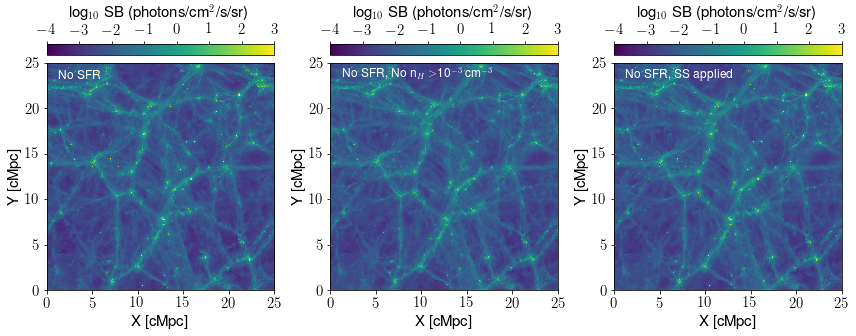

In [12]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,12))

Vmin=-4; Vmax=3
#Vmin=None; Vmax=None
xystarts = [0,0]
xyextent = [25.,25.]

pltimg(halpha376_noSFR,ax1,xystarts,xyextent,label=r'No SFR',colmap = 'viridis',
       colorbar=True,labelaxes=True,Vmin=Vmin,Vmax=Vmax)

pltimg(halpha376_noSFR_ss,ax2,xystarts,xyextent,label=r'No SFR, No n$_H>$10$^{-3}$ cm$^{-3}$',colmap = 'viridis',
       colorbar=True,labelaxes=True,Vmin=Vmin,Vmax=Vmax)

pltimg(halpha376_noSFR_ss_neutfrac,ax3,xystarts,xyextent,label='No SFR, SS applied',colmap = 'viridis',
       colorbar=True,labelaxes=True,Vmin=Vmin,Vmax=Vmax)


plt.tight_layout()

Zoom in a bit.

Top Left: With star-forming <br>
Top Right: No star-forming <br>
Bottom Left: No gas with nH above 10^-3 <br>
Bottom Right: No self-shielded gas, using neutral fraction <br>

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


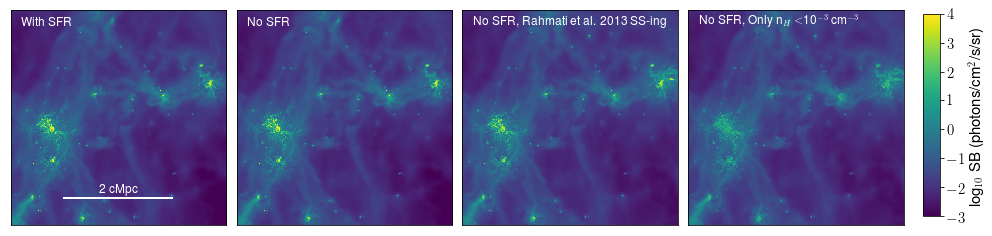

In [93]:
import matplotlib
from matplotlib.font_manager import FontProperties
font = FontProperties()
thisfont = font.copy()
thisfont.set_weight('medium')
thisfont.set_size('large')
plt.rcParams["font.weight"] = "bold"
thisfont.set_weight('bold')

#fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,12))
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(16,4))

Vmin=-3; Vmax=4

pixsize = halpha376_noSFR.shape[0]
boxsize = 25.
xystarts = [12,6]
xyextent = [4,4]
subset = [xystarts[0]/boxsize*pixsize,(xystarts[0]+xyextent[0])/boxsize*pixsize,
          xystarts[1]/boxsize*pixsize,(xystarts[1]+xyextent[1])/boxsize*pixsize]

labels = [r'With SFR',r'No SFR',r'No SFR, Rahmati et al. 2013 SS-ing',r'No SFR, Only n$_H<$10$^{-3}$ cm$^{-3}$']
colorbars = [False, False, False, True]

pltimg(halpha376_total[subset[0]:subset[1],subset[2]:subset[3]],
       ax1,xystarts,xyextent,label=r'With SFR',colmap = 'viridis',colorbar=colorbars[0],labelaxes=True,
       Vmin=Vmin,Vmax=Vmax)

pltimg(halpha376_noSFR[subset[0]:subset[1],subset[2]:subset[3]],
       ax2,xystarts,xyextent,label=r'No SFR',colmap = 'viridis',colorbar=colorbars[1],labelaxes=True,
       Vmin=Vmin,Vmax=Vmax)

pltimg(halpha376_noSFR_ss_neutfrac[subset[0]:subset[1],subset[2]:subset[3]],
       ax3,xystarts,xyextent,label=r'No SFR, Rahmati et al. 2013 SS-ing',colmap = 'viridis',
       colorbar=colorbars[2],labelaxes=True,Vmin=Vmin,Vmax=Vmax)

pltimg(halpha376_noSFR_ss[subset[0]:subset[1],subset[2]:subset[3]],
       ax4,xystarts,xyextent,label=r'No SFR, Only n$_H<$10$^{-3}$ cm$^{-3}$',colmap = 'viridis',
       colorbar=colorbars[3],labelaxes=True,Vmin=Vmin,Vmax=Vmax,cticks=[-3,-2,-1,0,1,2,3,4],
       orientation = 'vertical',cax=plt.axes([0.917, 0.15, 0.015, 0.7]) )

ax1.plot([13,15],[6.5,6.5],color='white',linewidth=2)
ax1.text(14,6.6,'2 cMpc', horizontalalignment='center',color='white',fontsize=15,fontweight='bold',fontproperties=thisfont)

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_xticks([])
fig.subplots_adjust( wspace=0.05, hspace=0.05, bottom=0.1, right=0.9)#, top=0.9)

plt.savefig('EAGLE_selfshielding_maps.pdf')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


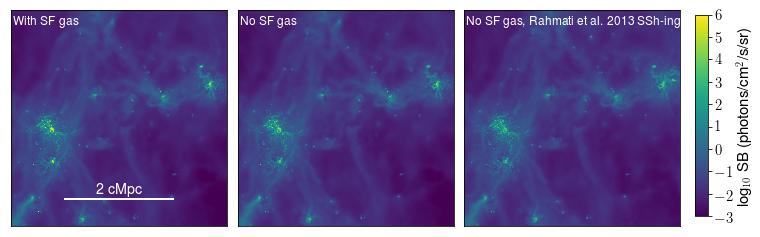

In [21]:
import matplotlib
from matplotlib.font_manager import FontProperties
font = FontProperties()
thisfont = font.copy()
thisfont.set_weight('medium')
thisfont.set_size('large')
plt.rcParams["font.weight"] = "bold"
thisfont.set_weight('bold')

#fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,12))
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))

Vmin=-3; Vmax=6

pixsize = halpha376_noSFR.shape[0]
boxsize = 25.
xystarts = [12,6]
xyextent = [4,4]
subset = [xystarts[0]/boxsize*pixsize,(xystarts[0]+xyextent[0])/boxsize*pixsize,
          xystarts[1]/boxsize*pixsize,(xystarts[1]+xyextent[1])/boxsize*pixsize]

labels = [r'With SFR',r'No SFR',r'No SFR, Rahmati et al. 2013 SS-ing',r'No SFR, Only n$_H<$10$^{-3}$ cm$^{-3}$']
colorbars = [False, False, False, True]

pltimg(halpha376_total[subset[0]:subset[1],subset[2]:subset[3]],
       ax1,xystarts,xyextent,label=r'With SF gas',colmap = 'viridis',colorbar=colorbars[0],labelaxes=True,
       Vmin=Vmin,Vmax=Vmax)

pltimg(halpha376_noSFR[subset[0]:subset[1],subset[2]:subset[3]],
       ax2,xystarts,xyextent,label=r'No SF gas',colmap = 'viridis',colorbar=colorbars[1],labelaxes=True,
       Vmin=Vmin,Vmax=Vmax)

pltimg(halpha376_noSFR_ss_neutfrac[subset[0]:subset[1],subset[2]:subset[3]],
       ax3,xystarts,xyextent,label=r'No SF gas, Rahmati et al. 2013 SSh-ing',colmap = 'viridis',
       colorbar=colorbars[3],labelaxes=True,Vmin=Vmin,Vmax=Vmax,cticks=[-3,-2,-1,0,1,2,3,4,5,6],
       orientation = 'vertical',cax=plt.axes([0.917, 0.15, 0.015, 0.7]) )

#pltimg(halpha376_noSFR_ss[subset[0]:subset[1],subset[2]:subset[3]],
#       ax4,xystarts,xyextent,label=r'No SFR, Only n$_H<$10$^{-3}$ cm$^{-3}$',colmap = 'viridis',
#       colorbar=colorbars[3],labelaxes=True,Vmin=Vmin,Vmax=Vmax,cticks=[-3,-2,-1,0,1,2,3,4],
#       orientation = 'vertical',cax=plt.axes([0.917, 0.15, 0.015, 0.7]) )

ax1.plot([13,15],[6.5,6.5],color='white',linewidth=2)
ax1.text(14,6.6,'2 cMpc', horizontalalignment='center',color='white',fontsize=15,fontweight='bold',fontproperties=thisfont)

for ax in [ax1,ax2,ax3]:
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_xticks([])
fig.subplots_adjust( wspace=0.05, hspace=0.05, bottom=0.1, right=0.9)#, top=0.9)

plt.savefig('EAGLE_selfshielding_maps_3cases.pdf')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


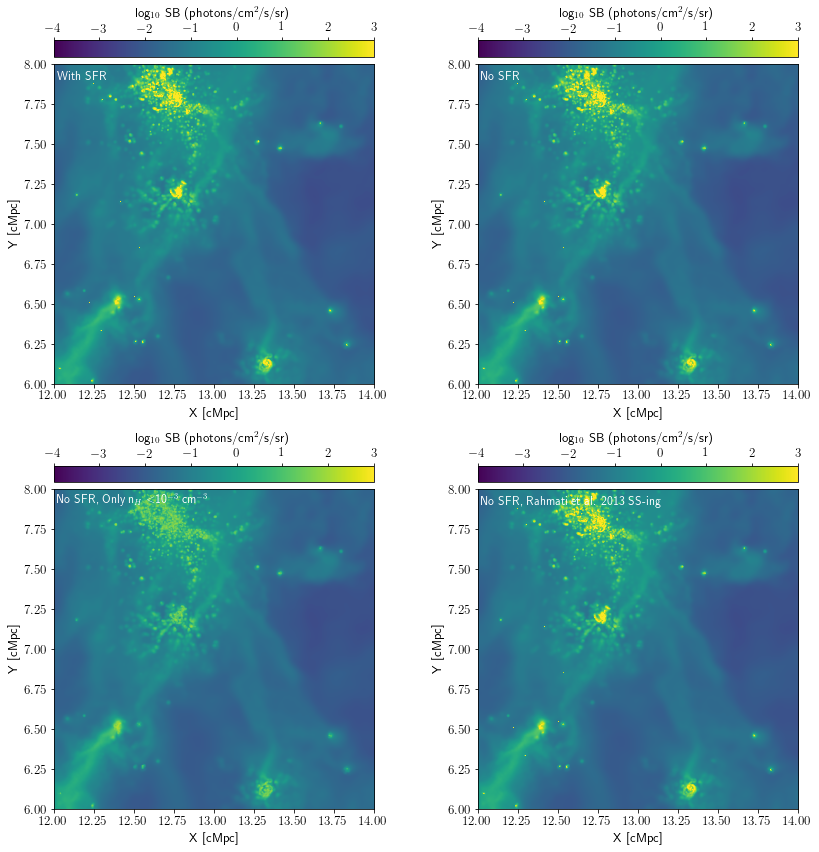

In [25]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,12))

Vmin=-4; Vmax=3

pixsize = halpha376_noSFR.shape[0]
boxsize = 25.
xystarts = [12,6]
xyextent = [2,2]
subset = [xystarts[0]/boxsize*pixsize,(xystarts[0]+xyextent[0])/boxsize*pixsize,
          xystarts[1]/boxsize*pixsize,(xystarts[1]+xyextent[1])/boxsize*pixsize]

labels = [r'With SFR',r'No SFR',r'No SFR, Only n$_H<$10$^{-3}$ cm$^{-3}$',r'No SFR, Rahmati et al. 2013 SS-ing']

pltimg(halpha376_total[subset[0]:subset[1],subset[2]:subset[3]],
       ax1,xystarts,xyextent,label=labels[0],colmap = 'viridis',colorbar=True,labelaxes=True,
       Vmin=Vmin,Vmax=Vmax)

pltimg(halpha376_noSFR[subset[0]:subset[1],subset[2]:subset[3]],
       ax2,xystarts,xyextent,label=labels[1],colmap = 'viridis',colorbar=True,labelaxes=True,
       Vmin=Vmin,Vmax=Vmax)

pltimg(halpha376_noSFR_ss[subset[0]:subset[1],subset[2]:subset[3]],
       ax3,xystarts,xyextent,label=labels[2],colmap = 'viridis',colorbar=True,labelaxes=True,
       Vmin=Vmin,Vmax=Vmax)

pltimg(halpha376_noSFR_ss_neutfrac[subset[0]:subset[1],subset[2]:subset[3]],
       ax4,xystarts,xyextent,label=labels[3],colmap = 'viridis',colorbar=True,labelaxes=True,
       Vmin=Vmin,Vmax=Vmax)

plt.tight_layout()

We should also compare the 

## azimuthal profiles.. 

In [14]:
verbose = True
import eagleSqlTools as sql

def databasequery(mySim = ('RefL0100N1504',100.),zmin=0,zmax=20):
    con   = sql.connect("dlokhorst",password="mxdPB54Y")  
    myQuery = "SELECT \
            SH.StarFormationRate as SFR, \
            SH.CentreOfPotential_x as sh_x,\
            SH.CentreOfPotential_y as sh_y,\
            SH.CentreOfPotential_z as sh_z,\
            SH.MassType_Star as mstar,\
            SH.MassType_DM as mdark,\
            FOF.Group_R_Crit200 as R200,\
            FOF.Group_M_Crit200 as M200, \
            FOF.Group_R_TopHat200 as RTopHat, \
            FOF.Group_M_TopHat200 as MTopHat, \
            SH.HalfMassProjRad_Star, \
            SH.HalfMassProjRad_Gas, \
            FOF.GroupMass as fof_mass\
        FROM   \
            %s_Subhalo as SH, \
            %s_FOF as FOF  \
        WHERE   \
            SH.MassType_Star > 1.0e8     \
            and SH.SnapNum = 28 \
            and SH.CentreOfPotential_z >= %s \
            and SH.CentreOfPotential_z <= %s \
            and FOF.SnapNum = SH.SnapNum \
            and FOF.GroupID = SH.GroupID"%(mySim[0],mySim[0],zmin,zmax)

    if verbose:
        print myQuery
    
    myData = sql.execute_query(con,myQuery)

    #sfr  = myData['SFR'][:]
    # Location of the galaxy
    xgal = myData['sh_x'][:]                  # cMpc
    ygal = myData['sh_y'][:]                  # cMpc
    zgal = myData['sh_z'][:]                  # cMpc
    # Stellar Mass of the galaxy
    mgal = myData['mstar'][:]                 # M_solar
    mdark = myData['mdark'][:]                # M_solar
    # Effective Radii
    rhgas = myData['HalfMassProjRad_Gas'][:]  # pkpc
    rhstar= myData['HalfMassProjRad_Star'][:] # pkpc
    # Virial Radii and Halo Masses
    R200 = myData['R200'][:]                  # pkpc
    M200 = myData['M200'][:]                  # M_solar
    RTopHat = myData['RTopHat'][:]            # pkpc
    MTopHat = myData['MTopHat'][:]            # M_solar

    print 'DONE.'
    return xgal,ygal,zgal,mgal,mdark,rhgas,rhstar,R200,M200,RTopHat,MTopHat

#xgal,ygal,zgal,mgal,rhgas,rhstar,R200,M200,RTopHat,MTopHat = databasequery()

In [15]:
class SimGalaxies:
    """A simple class containing information about galaxies in the EAGLE galaxy catalogue for a specific simulation run"""

    def __init__(self, simnum, simsize, resolution = 6.4):
        self.data = []
        self.num  = simnum
        self.size = simsize
        
        # Load data into dictionaries
        self.data8to9,self.data8up,self.data910,self.data1011,self.data11up,self.data9up,self.data10up,self.data95up = self.read_catalogue(resolution)
        
    def read_catalogue(self,resolution):
        xgal,ygal,zgal,mgal,mdark,rhgas,rhstar,R200,M200,RTopHat,MTopHat = databasequery(mySim = (self.num,self.size))
        
        Mpcperpix = 0.477/1000.*(1.+0.0235) * resolution
        # Condition (use bitwise "&" and not boolean "and")
        condition_10andup_all = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                                         (rhgas*5. > (Mpcperpix*1000.)) &
                                         (mgal > 10**10) 
                                    )
        condition_9to10_all = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                                       (rhgas*5. > (Mpcperpix*1000.)) &
                                       (mgal > 10**9) & (mgal <= 10**10)
                                  )
        condition_8to9_all = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                                       (rhgas*5. > (Mpcperpix*1000.)) &
                                       (mgal > 10**8) & (mgal <= 10**9)
                                  )

        condition_8andup_all = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                                         (rhgas*5. > (Mpcperpix*1000.)) &
                                         (mgal > 10**8) 
                                       )
                                        
        condition_9andup_all = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                                         (rhgas*5. > (Mpcperpix*1000.)) &
                                         (mgal > 10**9) 
                                    )
                                        
        condition_95andup_all = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                                         (rhgas*5. > (Mpcperpix*1000.)) &
                                         (mgal > 2.*10**9) 
                                    )
        condition_10to11_all = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                                       (rhgas*5. > (Mpcperpix*1000.)) &
                                       (mgal > 10**10) & (mgal <= 10**11)
                                  )
        condition_11andup = np.array( (mgal > 10**11) & (rhstar*5. > (Mpcperpix*1000.)) & 
                                     (rhgas*5. > (Mpcperpix*1000.)) )
        
       # condition_10andup_all = np.array( (mgal > 10**10) )
       # condition_9andup_all = np.array(   (mgal > 10**9) )
       # condition_8andup_all = np.array(   (mgal > 10**8) )
       # condition_9to10_all  = np.array(  (mgal > 10**9) & (mgal <= 10**10)  )
       # condition_10to11_all = np.array(  (mgal > 10**10) & (mgal <= 10**11)  )
       # condition_11andup    = np.array(  (mgal > 10**11)  )

        def makeselection(condition=condition_11andup):
            ii = np.array(np.where(condition)[0])
            dict_ii = {}
            dict_ii['xgal']    = np.array(xgal[ii])
            dict_ii['ygal']    = np.array(ygal[ii])
            dict_ii['mgal']    = np.array(mgal[ii])
            dict_ii['rhstar']  = np.array(rhstar[ii])
            dict_ii['R200']    = np.array(R200[ii])
            dict_ii['M200']    = np.array(M200[ii])
            dict_ii['RTopHat'] = np.array(RTopHat[ii])
            dict_ii['MTopHat'] = np.array(MTopHat[ii])
            dict_ii['mdark']  = np.array(mdark[ii])
            dict_ii['rhgas']  = np.array(rhgas[ii])
            return dict_ii

                                        
        dict_8andup_all = makeselection(condition=condition_8andup_all)               
        print 'Number of galaxies above 10^8 Msolar is: \t %s'%len(dict_8andup_all['ygal'])

        dict_9andup_all = makeselection(condition=condition_9andup_all)
        print 'Number of galaxies above 10^9 Msolar is: \t %s'%len(dict_9andup_all['ygal'])

        dict_95andup_all = makeselection(condition=condition_95andup_all)
        print 'Number of galaxies above 5*10^9 Msolar is: \t %s'%len(dict_95andup_all['ygal'])
        
        dict_10andup_all = makeselection(condition=condition_10andup_all)
        print 'Number of galaxies above 10^10 Msolar is: \t %s'%len(dict_10andup_all['ygal'])

        dict_11andup_all = makeselection(condition=condition_11andup)
        print 'Number of galaxies above 10^11 Msolar is: \t %s'%len(dict_11andup_all['ygal'])

        dict_8to9_all = makeselection(condition=condition_8to9_all)
        print 'Number of galaxies between 10^8 and 10^9 Msolar is: \t %s'%len(dict_8to9_all['ygal'])

        dict_9to10_all = makeselection(condition=condition_9to10_all)
        print 'Number of galaxies between 10^9 and 10^10 Msolar is: \t %s'%len(dict_9to10_all['ygal'])
        
        dict_10to11_all = makeselection(condition=condition_10to11_all)
        print 'Number of galaxies between 10^10 and 10^11 Msolar is: \t %s'%len(dict_10to11_all['ygal'])

        ## Check that they add up correctly:
        if (len(dict_9to10_all['RTopHat'])+len(dict_10to11_all['RTopHat'])+ len(dict_11andup_all['RTopHat']))==len(dict_9andup_all['ygal']):
            print 'TEST PASSED'
        else:
            print 'TEST FAILED'
            
        return dict_8to9_all,dict_8andup_all,dict_9to10_all,dict_10to11_all,dict_11andup_all,dict_9andup_all,dict_10andup_all,dict_95andup_all

    
    def read_catalogue2(self,resolution):
        xgal,ygal,zgal,mgal,mdark,rhgas,rhstar,R200,M200,RTopHat,MTopHat = databasequery(mySim = (self.num,self.size))
        
        Mpcperpix = 0.477/1000.*(1.+0.0235) * resolution
        # Condition (use bitwise "&" and not boolean "and")
        condition_10andup_all = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                                         (rhgas*5. > (Mpcperpix*1000.)) &
                                         (mdark > 10**10) 
                                    )
        condition_9to10_all = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                                       (rhgas*5. > (Mpcperpix*1000.)) &
                                       (mdark > 10**9) & (mdark <= 10**10)
                                  )

        condition_9andup_all = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                                         (rhgas*5. > (Mpcperpix*1000.)) &
                                         (mdark > 10**9) 
                                    )
        condition_95andup_all = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                                         (rhgas*5. > (Mpcperpix*1000.)) &
                                         (mdark > 2.*10**9) 
                                    )
        condition_10to11_all = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                                       (rhgas*5. > (Mpcperpix*1000.)) &
                                       (mdark > 10**10) & (mdark <= 10**11)
                                  )
        condition_11andup = np.array( (mdark > 10**11.2) & (rhstar*5. > (Mpcperpix*1000.)) & 
                                     (rhgas*5. > (Mpcperpix*1000.)) )
        
        #condition_10andup_all = np.array( (mgal > 10**10) )
        #condition_9andup_all = np.array(   (mgal > 10**9) )
        #condition_9to10_all  = np.array(  (mgal > 10**9) & (mgal <= 10**10)  )
        #condition_10to11_all = np.array(  (mgal > 10**10) & (mgal <= 10**11)  )
        #condition_11andup    = np.array(  (mgal > 10**11)  )

        def makeselection(condition=condition_11andup):
            ii = np.array(np.where(condition)[0])
            dict_ii = {}
            dict_ii['xgal']    = np.array(xgal[ii])
            dict_ii['ygal']    = np.array(ygal[ii])
            dict_ii['mgal']    = np.array(mgal[ii])
            dict_ii['rhstar']  = np.array(rhstar[ii])
            dict_ii['R200']    = np.array(R200[ii])
            dict_ii['M200']    = np.array(M200[ii])
            dict_ii['RTopHat'] = np.array(RTopHat[ii])
            dict_ii['MTopHat'] = np.array(MTopHat[ii])
            dict_ii['mdark']  = np.array(mdark[ii])
            return dict_ii

        dict_9andup_all = makeselection(condition=condition_9andup_all)
        print 'Number of galaxies WITH DM above 10^9 Msolar is: \t %s'%len(dict_9andup_all['ygal'])

        dict_95andup_all = makeselection(condition=condition_95andup_all)
        print 'Number of galaxies WITH DM above 5*10^9 Msolar is: \t %s'%len(dict_95andup_all['ygal'])
        
        dict_10andup_all = makeselection(condition=condition_10andup_all)
        print 'Number of galaxies WITH DM above 10^10 Msolar is: \t %s'%len(dict_10andup_all['ygal'])

        dict_11andup_all = makeselection(condition=condition_11andup)
        print 'Number of galaxies WITH DM above 10^11 Msolar is: \t %s'%len(dict_11andup_all['ygal'])

        dict_9to10_all = makeselection(condition=condition_9to10_all)
        print 'Number of galaxies WITH DM between 10^9 and 10^10 Msolar is: \t %s'%len(dict_9to10_all['ygal'])
        
        dict_10to11_all = makeselection(condition=condition_10to11_all)
        print 'Number of galaxies WITH DM between 10^10 and 10^11 Msolar is: \t %s'%len(dict_10to11_all['ygal'])

        ## Check that they add up correctly:
        if (len(dict_9to10_all['RTopHat'])+len(dict_10to11_all['RTopHat'])+ len(dict_11andup_all['RTopHat']))==len(dict_9andup_all['ygal']):
            print 'TEST PASSED'
        else:
            print 'TEST FAILED'
            
        return dict_9to10_all,dict_10to11_all,dict_11andup_all,dict_9andup_all,dict_10andup_all,dict_95andup_all


In [16]:
def radial_profile(data, center):
    data = 10**data
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())  ## radial profile before dividing by num of data points
    nr = np.bincount(r.ravel())                  ## num of data points
    radialprofile = tbin / nr
    return np.log10(radialprofile )

In [17]:
def Halphaprofileplot(data,xgal,ygal,boxsize,rhstar=None,linewidth=1,color='black',linestyle='-',
                          ax1=None,label=None,method='median',title = '',boxlength = 100.,plotgals=False):
    
    if ax1 is None:
        f, (ax1) = plt.subplots(1, 1,figsize=(5,5))
    ax1.set_title(title)
    ax1.set_ylim(-4,8)
    ax1.set_xlabel('radius [kpc]')
    
    azprofiles=[]; radius=[]; length = len(ygal); title=title
#    kpcperpix = 0.477/1000.*(1.+0.0235) * resolution * 1000. # at 100 Mpc from us
#    radius = np.arange(46) * kpcperpix
    
    edgecasecount = 0
    for j in range(length):
        minx,miny,maxx,maxy = xgal[j]-boxsize/2.,ygal[j]-boxsize/2.,xgal[j]+boxsize/2.,ygal[j]+boxsize/2.
        xystarts_tiny=[minx,miny]; size_tiny=[boxsize,boxsize] 
        
       # print minx,maxx,miny,maxy
       # print xystarts_tiny,size_tiny
        xsize = data.shape[0]; ysize = data.shape[1]
        data_tiny=data[minx*xsize/boxlength:maxx*xsize/boxlength,miny*ysize/boxlength:maxy*ysize/boxlength]

       # print data_tiny.shape
        
        if plotgals:
            f, (ax) = plt.subplots(1, 1,figsize=(5,5))
            xystarts=xystarts_tiny; xsize,ysize = boxsize,boxsize; Vmin = -4; Vmax = 4; colmap = 'viridis'
            ax.imshow(data_tiny.T,extent=(xystarts[0],xystarts[0]+xsize,xystarts[1],xystarts[1]+ysize),origin='lower',\
                        cmap=cm.get_cmap(colmap),interpolation='nearest', vmin = Vmin, vmax=Vmax)

        center, radi = (data_tiny.shape[0]/2,data_tiny.shape[1]/2), 55
        rad = radial_profile(data_tiny, center)
        
       # print center
       # print len(rad)
       # print ''
        kpcperpix = boxlength/data.shape[0] * 1000.
        numpix_expected = int(np.sqrt(2*data_tiny.shape[0]**2)/2)+1
        radius = np.arange(numpix_expected) * kpcperpix
        
      #  print kpcperpix
      #  print expected
        
        if len(rad)==numpix_expected:
            azprofiles.append(rad)
            if method=='none':
                ax1.plot(radius,rad)
            elif method!='justmedian':
                ax1.plot(radius,rad,color='lightgrey',zorder=1,alpha=0.5)
           # if rhstar is not None:
           #     ax1.plot([rhstar[j],rhstar[j]],[-4,8],color='peachpuff',zorder=1,alpha=0.3)
        else:
            'catch edge cases'
            #print "The length of the profile (x,y=%s,%s) is not correct, length: %s"%\
            #            (minx+boxsize/2,miny+boxsize/2,len(rad))
            edgecasecount = edgecasecount+1

    if edgecasecount>0:
        print "NOTE:   There were %s edge cases thrown out (out of total %s galaxies)"%(edgecasecount,length)
    
    azprofiles = np.array(azprofiles)
    
    if method=='average':
        meanprofile = np.log10(np.mean(10**(azprofiles), axis=0))
        sigmaprofile = np.log10(np.std(10**(azprofiles), axis=0))
        lowerr  = np.log10( 10**meanprofile - (10**sigmaprofile) ) 
        higherr = np.log10( 10**meanprofile + (10**sigmaprofile) ) 
        ax1.plot(radius,lowerr,color=color,linestyle='--')
        ax1.plot(radius,higherr,color=color,linestyle='--')
        ax1.plot(radius,meanprofile,color=color,linestyle='-') 
        return meanprofile,lowerr,higherr
    elif 'median' in method:
        medianprofile = np.log10(np.median(10**(azprofiles), axis=0))
        p25profile = np.percentile(azprofiles, 25, axis=0)
        p75profile = np.percentile(azprofiles, 75, axis=0)
        ax1.plot(radius,medianprofile,color=color,linestyle=linestyle,label=label,zorder=3,linewidth=linewidth)
      #  ax1.plot(radius,p25profile,color=color,linestyle='--',label='25 percentile') 
      #  ax1.plot(radius,p75profile,color=color,linestyle='--',label='75 percentile') 
        if method!='justmedian':
            ax1.fill_between(radius,p25profile, p75profile, facecolor =color,alpha=0.2,zorder=4)
        if rhstar is not None:
            ax1.plot([np.median(rhstar),np.median(rhstar)],[-4,8],color='orange',linewidth=2,zorder=2,alpha=0.5)
        return medianprofile,p25profile,p75profile
    else:
        print 'No method of statistic-ing the data selected.  Returning no profiles, watch out!'

In [18]:
ref376 = SimGalaxies('RefL0025N0376',25.)

SELECT             SH.StarFormationRate as SFR,             SH.CentreOfPotential_x as sh_x,            SH.CentreOfPotential_y as sh_y,            SH.CentreOfPotential_z as sh_z,            SH.MassType_Star as mstar,            SH.MassType_DM as mdark,            FOF.Group_R_Crit200 as R200,            FOF.Group_M_Crit200 as M200,             FOF.Group_R_TopHat200 as RTopHat,             FOF.Group_M_TopHat200 as MTopHat,             SH.HalfMassProjRad_Star,             SH.HalfMassProjRad_Gas,             FOF.GroupMass as fof_mass        FROM               RefL0025N0376_Subhalo as SH,             RefL0025N0376_FOF as FOF          WHERE               SH.MassType_Star > 1.0e8                 and SH.SnapNum = 28             and SH.CentreOfPotential_z >= 0             and SH.CentreOfPotential_z <= 20             and FOF.SnapNum = SH.SnapNum             and FOF.GroupID = SH.GroupID
DONE.
Number of galaxies above 10^8 Msolar is: 	 509
Number of galaxies above 10^9 Msolar is: 	 188
Number of ga

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


NOTE:   There were 1 edge cases thrown out (out of total 65 galaxies)
NOTE:   There were 1 edge cases thrown out (out of total 65 galaxies)
NOTE:   There were 1 edge cases thrown out (out of total 65 galaxies)


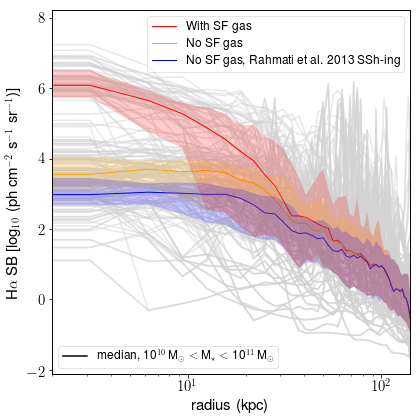

In [19]:
f, (ax1) = plt.subplots(1, 1,figsize=(6,6))
boxsize = 0.2

#Mpcperpix = 0.477/1000.*(1.+0.0235) * resolution # 100 Mpc away from us
#kpcperpix = 0.477/1000.*(1.+0.0235) * resolution * 1000. # 100 Mpc away from us

Halphaprofileplot(halpha376_total,   ref376.data1011['xgal'],ref376.data1011['ygal'],
                  boxsize,ax1=ax1,boxlength = 25.,color='red',label='With SF gas');
Halphaprofileplot(halpha376_noSFR,   ref376.data1011['xgal'],ref376.data1011['ygal'],
                  boxsize,ax1=ax1,boxlength = 25.,color='orange',label='No SF gas');
Halphaprofileplot(halpha376_noSFR_ss_neutfrac,ref376.data1011['xgal'],ref376.data1011['ygal'],
                  boxsize,ax1=ax1,boxlength = 25.,color='blue',label='No SF gas, Rahmati et al. 2013 SSh-ing');
#Halphaprofileplot(halpha376_noSFR_ss,ref376.data1011['xgal'],ref376.data1011['ygal'],
#                  boxsize,ax1=ax1,boxlength = 25.,color='black',label=r'No SFR, Only n$_H < 10^{-3}$ cm$^{-3}$');

ax1.legend(loc=1, framealpha=0.5)
ax1.set_ylabel(r'H$\alpha$ SB [log$_{10}$ (ph cm$^{-2}$ s$^{-1}$ sr$^{-1}$)]')

for ax in [ax1]:
    ax.set_xlim(2.,140)
    ax.set_ylim(-2.,8)

ax2 = ax1.twiny()
#ax4 = ax3.twiny()
for ax in [ax2]:
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_xticks([])
#for ax in [ax1]:
#    ax.set_yticklabels([])
#    ax.set_ylabel('')

#title1 = r'median, 10$^9$ M$_{\odot}$ < M$_{\star}$ < 10$^{10}$ M$_{\odot}$'
title2 = r'median, 10$^{10}$ M$_{\odot}$ $<$ M$_{\star}$ $<$ 10$^{11}$ M$_{\odot}$'
#title3 = r'median, M$_{\star}$ > 10$^{11}$ M$_{\odot}$'
#title4 = r'median, M$_{\star}$ > 10$^{9}$ M$_{\odot}$'
#ax2.plot(0,0,'k-',label=title1)
ax2.plot(0,0,'k-',label=title2)
#ax2.plot(0,0,'k-.',label=title3)
ax2.legend(loc=3, framealpha=0.5)
#ax4.plot(0,0,'k-',label=title4)
#ax4.legend(loc=3, framealpha=0.5)

loglog = True
if loglog:
    for ax in [ax1]:
        ax.set_xscale('log')
    for ax in [ax1]:
        ax.set_xlabel(r'radius (kpc)')

#f.subplots_adjust( wspace = 0, top=.95)
plt.tight_layout()

plt.savefig('EAGLE_selfshielding_3cases.pdf')

### testing the neutral frac ss-ing code (just ran one slice initially, comparing to the other ss data)

halpha_25Mpc_376_SS:  run on March 5, 2019, using the new SS-ing code that uses Nastasha's calcfmass script to get the neutral fractions.

In [64]:
halpha376_noSFR_oneslice_fname = directory+'/niagara_20Jan2019/halpha_25Mpc_376/'+\
    'emission_halpha_L0025N0376_28_SmAb_C2Sm_8000pix_1.250000slice_zcen0.625_noSFR.npz'
halpha376_noSFR_ss_oneslice_fname = directory+'/halpha_ss/'+\
    'emission_halpha_L0025N0376_28_test2_SmAb_C2Sm_8000pix_1.250000slice_zcen0.625_noSFR_SS.npz'
halpha376_noSFR_ss_neutralfrac_oneslice_fname = directory+'/halpha_25Mpc_376_SS/'+\
    'emission_halpha_L0025N0376_28_SmAb_C2Sm_8000pix_1.250000slice_zcen0.625_noSFR_SS.npz'

oneslice = np.load(halpha376_noSFR_oneslice_fname)['arr_0']
oneslice_ss = np.load(halpha376_noSFR_ss_oneslice_fname)['arr_0']
oneslice_ss_neutfrac = np.load(halpha376_noSFR_ss_neutralfrac_oneslice_fname)['arr_0']

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


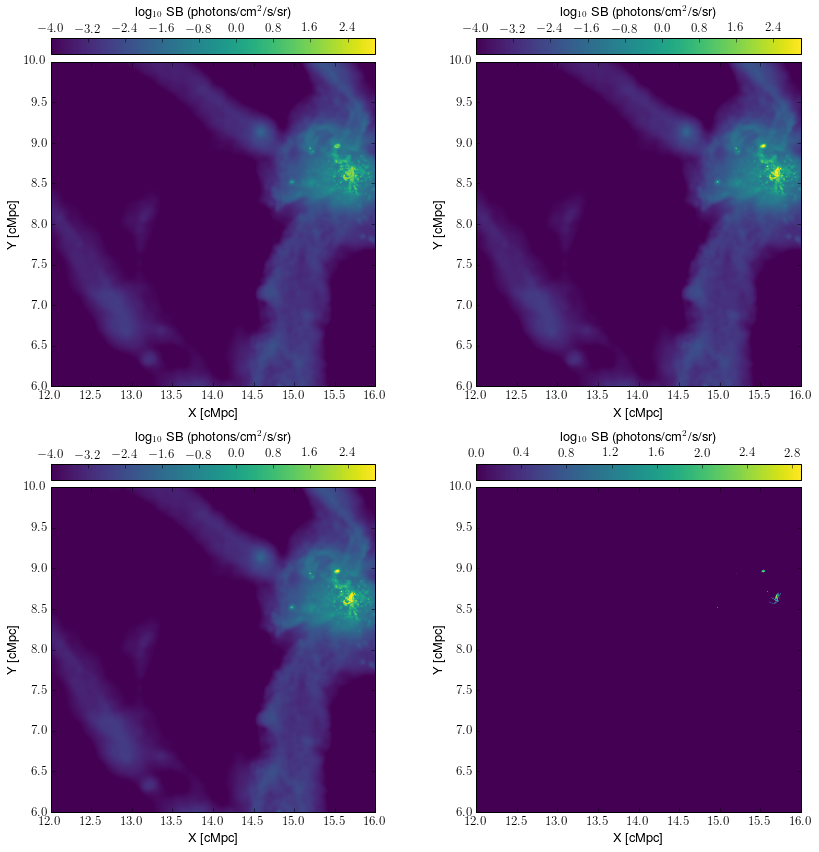

In [65]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,12))

pixsize = halpha376_noSFR.shape[0]
boxsize = 25.
xystarts = [12,6]
xyextent = [4,4]
Vmin=-4; Vmax=3

subset = [xystarts[0]/boxsize*pixsize,(xystarts[0]+xyextent[0])/boxsize*pixsize,
          xystarts[1]/boxsize*pixsize,(xystarts[1]+xyextent[1])/boxsize*pixsize]

pltimg(oneslice_ss[subset[0]:subset[1],subset[2]:subset[3]],
       ax1,xystarts,xyextent,label=None,colmap = 'viridis',colorbar=True,labelaxes=True,
       Vmin=Vmin,Vmax=Vmax)

pltimg(oneslice_ss_neutfrac[subset[0]:subset[1],subset[2]:subset[3]],
       ax2,xystarts,xyextent,label=None,colmap = 'viridis',colorbar=True,labelaxes=True,
       Vmin=Vmin,Vmax=Vmax)

pltimg(oneslice[subset[0]:subset[1],subset[2]:subset[3]],
       ax3,xystarts,xyextent,label=None,colmap = 'viridis',colorbar=True,labelaxes=True,
       Vmin=Vmin,Vmax=Vmax)

Vmin=None
Vmax = None
pltimg(oneslice_ss_neutfrac[subset[0]:subset[1],subset[2]:subset[3]]-oneslice_ss[subset[0]:subset[1],subset[2]:subset[3]],
       ax4,xystarts,xyextent,label=None,colmap = 'viridis',colorbar=True,labelaxes=True,
       Vmin=Vmin,Vmax=Vmax)

plt.tight_layout()